## Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Описание данных  
В качестве входных данных вы имеете 4 csv-файла:

* groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).   
* groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.  
* active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.   
* checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента.  

### Основные вопросы
На какие метрики вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

In [34]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest

In [35]:
# библиотека для кодировки данных в формат URL
from urllib.parse import urlencode
import requests

In [36]:
# Прописываем ссылки на файлы

groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [37]:
# Запускаем функцию на скачивание файлов по API Яндекса

def get_ydisk_url(public_key: str) -> str:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [38]:
# Открываем скаченные файлы

active_studs = pd.read_csv(get_ydisk_url(active_studs_url))
checks = pd.read_csv(get_ydisk_url(checks_url), sep=';')
group_add = pd.read_csv(get_ydisk_url(groups_add_url))
groups = pd.read_csv(get_ydisk_url(groups_url), sep=';')

1.1 Проверим как отображаются данные во всех файлах

In [39]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [40]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [41]:
group_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [42]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


1.2 Посмотрим на информацию которая хранится в данных каждого ДФ

In [43]:
print(active_studs.info())
print('*************************************')
print('*************************************')
print(checks.info())
print('*************************************')
print('*************************************')
print(group_add.info())
print('*************************************')
print('*************************************')
print(groups.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None
*************************************
*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None
*************************************
*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int6

По полученным данным видим, чот с ними всё в порядке, нет нулевых значений, типы данных тоже корректны.

In [44]:
# Соединим groups и group_add, для получения полной табицы с id и их группами

all_students = pd.concat([groups, group_add], ignore_index=True)

In [45]:
# Для подготовки к слиянию следующих таблиц, переименуем в двух таблицах id студентов, что бы они были везде одинаковые
# В таблице с активными пользователями добавим признак 1, чтобы в дальнейшем понимать был активен пользователь или нет

checks = checks.rename(columns={'student_id': 'id'})
active_studs = active_studs.rename(columns={'student_id': 'id'})

active_studs['active'] = 1

In [46]:
# Здесь мы сольем все таблицы в один дата фрейм, заменим NaN на 0
# Проверим есть ли пользователи которые были не активны, но оплата по какой-то причине прошла

df = all_students.merge(active_studs, how='left', on='id').fillna(0)
full_df = df.merge(checks, how='left', on='id').fillna(0)


print(f"Не активные, но оплатившие пользователи: {full_df.query('active != 1 and rev > 0').count()['id']}")
print(f"Количество всех оплативших: {full_df.query('rev > 0').count()['id']}")
print(f"Доля не активных, но оплативших: {round(full_df.query('active != 1 and rev > 0').count()['id'] / full_df.query('rev > 0').count()['id'],2)}")

Не активные, но оплатившие пользователи: 149
Количество всех оплативших: 541
Доля не активных, но оплативших: 0.28


In [47]:
# Проверим уникальны ли все пользователи.

full_df.id.nunique() / full_df.id.count()

np.float64(1.0)

Из полученных данных мы узнали, что есть не активные, но оплатившие пользователи, и их почти 30%. Мы не будем с ними работать, так как если человек не увидел нашу новую механику оплаты, то он не смог её оценить, что для данного теста очень важно.

Также узнали что все пользователи в ДФ уникальны

In [48]:
# Отбираем только активных пользователей, и в дальнейшем работаем только с ними.

full_df_active = full_df.query('active == 1')

Расчитаем метрики которые нам могут быть интересны.

Количество активных пользователей в каждой группе, для понимания как их распределили для проведения теста

Выручка по пользователям, а также ARPU и ARPPU, для понимания какая группа больше приносит дохода

Конверсия в оплату, не мало важная метрика, для понимания в какой группе, и с каким механизмом оплаты люди чаще платят.

,grp,id
0,A,1538
1,B,6803


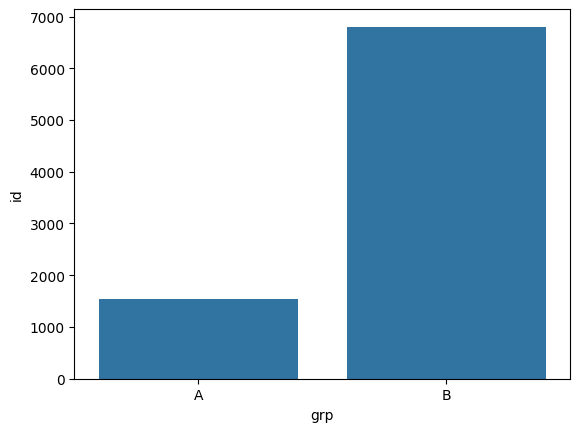

In [49]:
# Посмотрим на распределение студентов по группам.

sns.barplot(data=full_df_active.groupby('grp', as_index=False).count()[['grp', 'id']], x="grp", y='id')
full_df_active.groupby('grp', as_index=False).count()[['grp', 'id']]

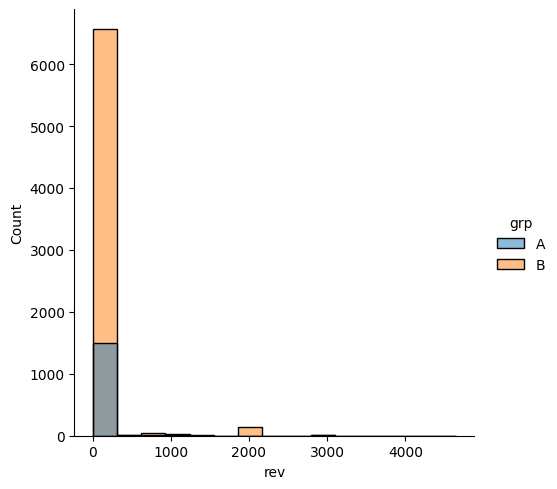

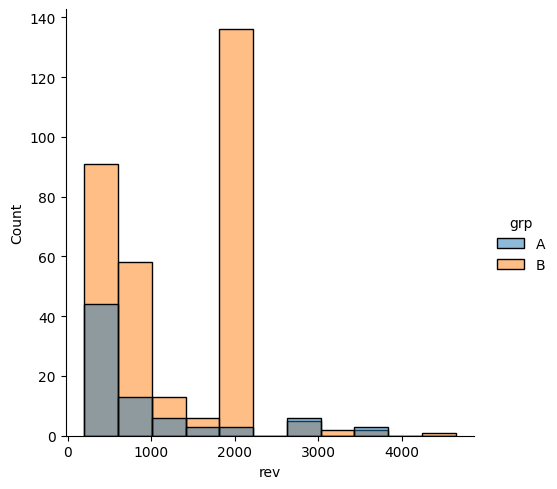

In [50]:
# Посмотрим на графике распределение полученной выручки по всем активным пользователям, и только по платящим в каждой группе

sns.displot(data=full_df_active, x="rev", hue="grp")
sns.displot(data=full_df_active.query('rev > 0'), x="rev", hue="grp")

In [51]:
# Раcсчитаем ARPU и ARPPU

ARPU = full_df_active.groupby('grp', as_index=False).mean()[['grp', 'rev']]
ARPPU = full_df_active.query('rev > 0').groupby('grp', as_index=False).mean()[['grp', 'rev']]
ARPU_ARPPU = ARPU.merge(ARPPU, how='left', on='grp')
ARPU_ARPPU.rename(columns={'rev_x': 'ARPU', 'rev_y': 'ARPPU'}, inplace=True)
ARPU_ARPPU

,grp,ARPU,ARPPU
0,A,47.347204,933.589744
1,B,58.058798,1257.878992


In [52]:
# Распределим по разным переменным разные группы, для дальнейшего расчета конверсии в оплату

active_group_a = full_df_active.query('grp == "A"')
active_group_b = full_df_active.query('grp == "B"')

In [53]:
# Посчитаем CR

pay_A = (active_group_a['rev'] > 0).sum()
all_A = len(active_group_a)
pay_B = (active_group_b['rev'] > 0).sum()
all_B = len(active_group_b)

cr_A = pay_A/all_A
cr_B = pay_B/all_B
print(f'CR контрольной группы = {cr_A}')
print(f'CR тестовой группы = {cr_B}')

CR контрольной группы = 0.05071521456436931
CR тестовой группы = 0.046156107599588415


#### Промежуточный вывод:

Первое наблюдение, которое может повлиять на результаты - это не правильное распределение количества студентов по группам. В тестовой группе гораздо больше студентов чем в контрольной. По хорошему, должно быть либо наоборот, либо одинаковое количество студентов в каждой группе, для более достоверных результатов. Сейчас это выглядит так, что вероятнее мы тестируем старый способ оплаты, вместо нового.

Второе, выручка и все связанные с ней метрики, на данный момент, показывают что дела обстоят лучше у тестовой группы, но всё ровно большинство студентов не совершают оплату в любой из групп, и в тестовой таких даже больше. Также мы видим не нормальное распределение выручки.

Третье, не смотря на всё вышесказанное, конверсия в оплату немного лучше у контрольной группы. Которая говорит нам, что люди чаще совершают оплату все же со старым механизмом.

<hr>

#### Проверим все на тестах

Так как распределение выручки не является нормальным, можно использовать тест Левена для определения равенства дисперсий, после оценки определим какой тест выбрать для сравнения средней выручки.

Для конверсии в оплату произведем z-тест

In [54]:
# создадим перменную для сравнения с p-value (стандарт - 5%)

alpha = 0.05

In [55]:
# Тест Левена по ARPU

levene_stat, levene_pvalue = levene(active_group_a['rev'], active_group_b['rev'])

print(f't-статистика: {levene_stat}')
print(f'p-значение: {levene_pvalue}')

if levene_pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Существует значимая разница в дисперсиях выручкки между группами A и B.")
else:
    print("Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в дисперсиях выручки между группами A и B.")

t-статистика: 1.501460829433639
p-значение: 0.22048133327049668
Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в дисперсиях выручки между группами A и B.


Так как разницы в дисперсиях мы не увидели, то можно провести t-test для сравнения средней выручки по всем активным пользователям.


In [56]:
# t-тест по ARPU

t_statistic, t_p_value = stats.ttest_ind(active_group_a['rev'], active_group_b['rev'], equal_var=True)

print(f't-статистика: {t_statistic}')
print(f'p-значение: {t_p_value}')
if t_p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует значимая разница в выручке между группами A и B.")
else:
    print("Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в выручке между группами A и B.")

t-статистика: -1.2253411073793445
p-значение: 0.22048133326988378
Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в выручке между группами A и B.


t-Тест показал нам что нет значимой разницы в ARPU между группами, что говорит нам о том, что нам не стоит запускать новую механику оплаты на всех пользователей

Но, для более достоверного результата, сделаем всё тоже самое, толко для ARPPU.

In [57]:
# Тест Левена по ARPPU

levene_stat, levene_pvalue = levene(active_group_a.query('rev > 0')['rev'], active_group_b.query('rev > 0')['rev'])

print(f't-статистика: {levene_stat}')
print(f'p-значение: {levene_pvalue}')

if levene_pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Существует значимая разница в дисперсиях выручкки между группами A и B.")
else:
    print("Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в дисперсиях выручки между группами A и B.")

t-статистика: 3.075681699981606
p-значение: 0.08025675761347023
Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в дисперсиях выручки между группами A и B.


In [58]:
# t-тест по ARPPU

t_statistic, t_p_value = stats.ttest_ind(active_group_a.query('rev > 0')['rev'], active_group_b.query('rev > 0')['rev'], equal_var=True)

print(f't-статистика: {t_statistic}')
print(f'p-значение: {t_p_value}')
if t_p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует значимая разница в выручке между группами A и B.")
else:
    print("Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в выручке между группами A и B.")

t-статистика: -3.1337795050930985
p-значение: 0.001856202526576587
Отвергаем нулевую гипотезу. Существует значимая разница в выручке между группами A и B.


Тут наступает интересный момент, по ARPPU разница в выручке есть, и нам можно отвергнуть нулевую гипотезу и запустить новый механизм оплаты.


Пока проведем тест над конверсией в оплату. Выберем тест на z-пропорции, так как он как раз предназначен для сравнения конверсий.

In [59]:
# z-тест для CR

z_stat, z_p_value = proportions_ztest([pay_A, pay_B], [all_A, all_B])

print(f"z-статистика: {z_stat}")
print(f"p-значение: {z_p_value}")

if z_p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует значимая разница в конверсиях в оплату между группами A и B.")
else:
    print("Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в конверсиях в оплату между группами A и B.")

z-статистика: 0.7629884495263746
p-значение: 0.445470284371589
Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в конверсиях в оплату между группами A и B.


Заключение к вопросам по заданию:

***На какие метрики вы смотрите в ходе анализа и почему?***

В ходе анализа была рассмотрена выручка и конверсия в оплату.

По плану, новый механизм в оплату должен спровоцирвать студентов чаще оплачивать.

Частые оплаты = выручка, ARPU, ARPPU и конверсия

***Имеются ли различия в показателях и с чем они могут быть связаны?***

Да, различия следующие:

  1) Т-статистика показала незначительные различия в средних данных по ARPU, но в тоже время различия наблюдаются в ARPPU

  2) Z-статистика показала что разница в конверсиях не значительна

***Являются ли эти различия статистически значимыми?***

Статистически значимые различия наблюдаются только в ARPPU, p-value < 0.05. По остальным метрикам их нет

***Стоит ли запускать новую механику на всех пользователей?***

На этот вопрос сложно ответить, не уточнив у заказчика на какую метрику должен повлиять тест.


**Заключение:**

Результаты тестов показали нам, что статистически значимые различия отсутствуют по ARPU и CR, но присутствуют в ARPPU. Перед одобрением запуска, нужно понять на что мы хотим повлиять. Если на среднюю выручку по всем студентам, то запускать не стоит, а  если на среднюю выручку по платящим то можно и запустить.

Второй момент, В тестовой группе у нас находилось гораздо больше людей чем в контрольной, что могло отразится на результатах тестов. Довольно опасано запускать тест на бОльшую долю пользователей из всей генеральной совокупности. Наши изменения могут как улучшить метрики, так и ухудшить, и в этом случае нужно быть аккуратным, так как пользователи могут вообще уйти из нашего продукта. По этому, лучше отделаться малой кровью при проведении каких либо экспериментов.

Рекомендации:

1) Уменьшить выборку в тестовой группе до значения контрольной, но лучше ниже, либо отобрать больше студентов в контрольной группе. И заного провести тесты.

2) Более точно понять на какую метрику, или метрики, наша гипотеза должна повлиять.


<hr>

## Задание 2. SQL

### Очень усердные ученики.

Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

 ### Задача 1 

Дана таблица peas:

| Название атрибута  | Тип атрибута  | Смысловое значение |
|:------------- |:---------------:| :-------------:|
| st_id         | int          | ID ученика        |
| timest        | timestamp    | Время решения карточки        |
| correct       | bool         | Правильно ли решена горошина?       |
| ubject        | text         |Дисциплина, в которой находится горошина    |



Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Ссылка на работу в Redash - https://redash.lab.karpov.courses/queries/56904/source

In [ ]:
-- Из таблицы peas отбираем уникальных студентов, и считаем количество сданных задач
SELECT DISTINCT st_id, count(correct) as cnt_correct
FROM peas
WHERE correct = true -- фильтруем по сданным задачам
GROUP BY st_id -- группируем по id студента
HAVING count(correct) >= 20; -- на финальной таблице (после выполнения SELECT) отфильтровываем по условию задачи '''

### Задача 2

***Условие***

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

***Задача***

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU

ARPAU

CR в покупку

СR активного пользователя в покупку

CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [ ]:
-- Для финального результата нам понадобятся CTE
-- Делаем по аналогии из прошлого задания, только кол-во решенных задач ставим по новому условию
WITH best_students AS (
SELECT st_id, count(correct) as cnt_correct
FROM peas
WHERE correct = true
GROUP BY st_id
HAVING count(correct) >= 10
),

-- Второй CTE, отбираем студентов кто решил 2 и более задачи по математике
math_active AS (
SELECT st_id, count(correct) as cnt_cor_math
FROM peas
WHERE correct = true and subject = 'Math'
GROUP BY st_id
HAVING count(correct) >= 2
),

-- Третий CTE, отбираем студентов кто оплатил математику
buy_math AS (
SELECT st_id as st_math_id
FROM final_project_check
WHERE subject = 'Math'
)

-- создаем финальный SELECT с расчетами сказанными в условии задачи
SELECT s.test_grp,
       sum(f.money)/count(distinct s.st_id) as ARPU,
       sum(f.money)/ count(distinct bs.st_id) as ARPAU,
       round((count(distinct f.st_id)/count(distinct s.st_id)::decimal)*100 ,2) as CR,
       round((count(distinct f.st_id)/count(distinct bs.st_id)::decimal)*100 ,2) as CR_active,
       round((count(distinct st_math_id)/count(distinct ma.st_id)::decimal)*100 ,2) as CR_math_active

-- Чтобы SELECT сработал, мы соединяем все CTE и таблицу studs друг с другом по id студента.
FROM studs as s
LEFT JOIN final_project_check as f
ON s.st_id=f.st_id
LEFT JOIN best_students as bs
ON s.st_id=bs.st_id
LEFT JOIN math_active as ma
ON s.st_id=ma.st_id
LEFT JOIN buy_math as bm
ON s.st_id=bm.st_math_id

GROUP BY s.test_grp -- группируем по группам '''

<hr>

## Задание 3. Python

###  Задача

* Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

* Реализуйте функцию, которая будет строить графики по получаемым метрикам.

*P.S. По задумке функции, при добавлении новых студентов, они должны присоединяться к полному файлу со студентами который у нас был в первом задании, но так как, по факту, мы работаем с тем же файлом что и в первом задании, я не стал дублировать данные, которые у нас уже есть, и сделал так как будто мы ещё не видели этот файл с новыми студентами.*

*Также можно сделать отдельны файл с расширением .py, написать там все функции. И в основном файле работать с ней загрузив через import "название файла с функцией без расширения", и далее прописать function.load_and_recalculate_metrics(group_add)*

In [62]:
file = 'Проект_2_group_add.csv'

def load_and_recalculate_metrics(file):
    # Загрузка файла и все манипуляции которые мы проводили в задании 1
    # Так как файл csv, то считываем его обычным пандовским методом
    new_groups = pd.read_csv(file)

    # Вместо groups, можно подставить all_students из первого задания, но не будем дублировать данные.
    groups_upd = pd.concat([groups, new_groups], ignore_index=True)
    active_groups_upd = groups_upd.merge(active_studs, how = 'left', on='id')
    upd_full_df = active_groups_upd.merge(checks, how='left', on='id').fillna(0)
    upd_full_df_active = upd_full_df.query('active == 1')

    # переменные для ARPU и ARPPU
    upd_ARPU = upd_full_df_active.groupby('grp', as_index=False).mean()[['grp', 'rev']]
    upd_ARPPU = upd_full_df_active.query('rev > 0').groupby('grp', as_index=False).mean()[['grp', 'rev']]
    upd_ARPPU.rename(columns={'rev': 'ARPPU'}, inplace=True)

    # расчет СR и преобразование в ДФ, для последующего соединения с другими ДФ
    upd_pay_A = (upd_full_df_active.query('grp == "A"')['rev'] > 0).sum()
    upd_all_A = len(upd_full_df_active.query('grp == "A"'))
    upd_pay_B = (upd_full_df_active.query('grp == "B"')['rev'] > 0).sum()
    upd_all_B = len(upd_full_df_active.query('grp == "B"'))
    upd_cr_A = upd_pay_A/upd_all_A
    upd_cr_B = upd_pay_B/upd_all_B
    # сделаем из серий CR сначала словарь, а потом ДФ, что бы можно было соединить с остальными ДФ
    dict_cr = {'grp': ['A', 'B'], 'СR': [upd_cr_A, upd_cr_B]}
    upd_cr = pd.DataFrame(dict_cr)

    # Cоединение всех ДФ
    upd_df = upd_full_df_active.groupby('grp', as_index=False).count()[['grp', 'id']]\
                                                              .merge(upd_cr, how='left', on='grp') \
                                                              .merge(upd_ARPU, how='left', on='grp') \
                                                              .merge(upd_ARPPU, how='left', on='grp')

    upd_df.rename(columns={'id': 'cnt_id', 'rev': 'ARPU'}, inplace=True)

    return upd_df


new_metrics = load_and_recalculate_metrics(file)
new_metrics

,grp,cnt_id,СR,ARPU,ARPPU
0,A,1538,0.050715,47.347204,933.589744
1,B,6803,0.046156,58.058798,1257.878992


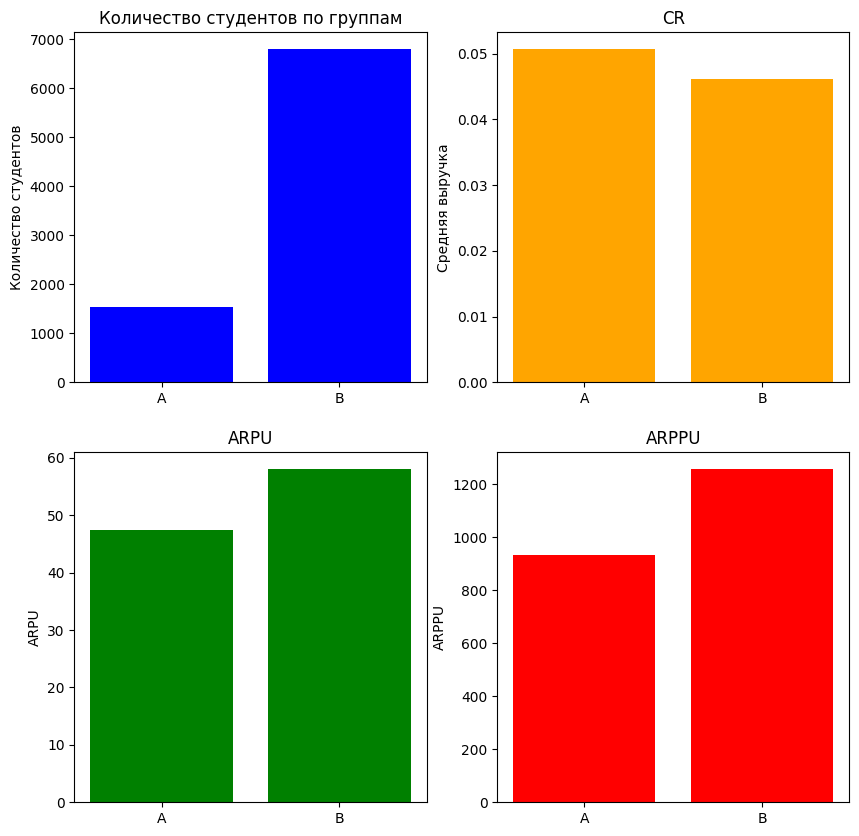

<Figure size 800x600 with 0 Axes>

In [63]:
def charts_metrics(new_metrics):


    # Создание столбчатых графиков для метрик по группам
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    plt.figure(figsize=(8, 6))
    axs[0, 0].bar(new_metrics['grp'], new_metrics['cnt_id'], color='blue')
    axs[0, 0].set_title('Количество студентов по группам')
    axs[0, 0].set_ylabel('Количество студентов')

    axs[0, 1].bar(new_metrics['grp'], new_metrics['СR'], color='orange')
    axs[0, 1].set_title('CR')
    axs[0, 1].set_ylabel('Средняя выручка')

    axs[1, 0].bar(new_metrics['grp'], new_metrics['ARPU'], color='green')
    axs[1, 0].set_title('ARPU')
    axs[1, 0].set_ylabel('ARPU')

    axs[1, 1].bar(new_metrics['grp'], new_metrics['ARPPU'], color='red')
    axs[1, 1].set_title('ARPPU')
    axs[1, 1].set_ylabel('ARPPU')

charts_metrics(new_metrics)